## Creating a Jupyter notebook in VSCode


We will create a simulated dataset from an experiment that includes 100 individuals, each tested on 20 different test items.  

Performance on each test is a function of a subject mean, an item difficulty, and random noise.  There should be three standard deviations specified: one for subjects, one for items, and one for random noise.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


In [2]:
# We will create a simulated dataset from an experiment that includes 100 individuals, each tested on 20 different test items.  

# The score on each test is a function of a subject mean, an item difficulty, and random noise.  
# There should be three standard deviations specified: one for subjects, one for items, and one for random noise.
# subjects are randomly assigned to one of two treatment conditions
# The goal is to estimate the effect of the treatment on performance, while controlling for subject and item effects.

n_subjects = 250
n_items = 20

subject_sd = 1
item_sd = 2
noise_sd = 3

treatment_effect = 0.5

rng = np.random.default_rng(12345)

subject_means = rng.normal(0, subject_sd, n_subjects)
item_difficulties = rng.normal(0, item_sd, n_items)
treatment_condition = rng.choice([0, 1], n_subjects)

df = pd.DataFrame()
df['subject'] = np.repeat(range(n_subjects), n_items)
df['item'] = np.tile(range(n_items), n_subjects)

df['subject_mean'] = subject_means[df['subject']]
df['item_difficulty'] = item_difficulties[df['item']]
df['treatment'] = treatment_condition[df['subject']]

df['score'] = df['subject_mean'] + df['item_difficulty'] + rng.normal(0, noise_sd, n_subjects * n_items) + treatment_effect * df['treatment']


In [3]:
# run a linear mixed effects model
# with a random intercept for both subjects and items

# necessary dummy variable
df["group"] = 1 


vcf = {"item": "0 + C(item)", "subject": "0 + C(subject)"}                                                         
model = sm.MixedLM.from_formula("score ~ treatment", groups="group",                                              
                                vc_formula=vcf, re_formula="0", data=df)                                                   
result = model.fit()  


In [4]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: score      
No. Observations: 5000    Method:             REML       
No. Groups:       1       Scale:              9.2697     
Min. group size:  5000    Log-Likelihood:     -12845.7086
Max. group size:  5000    Converged:          Yes        
Mean group size:  5000.0                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.305    0.508 -0.600 0.549 -1.300  0.690
treatment       0.519    0.149  3.482 0.000  0.227  0.811
item Var        4.954    0.533                           
subject Var     0.911    0.042                           
=========================================================

"""

## using the R magic

In [5]:
# requires that rpy2 has been installed
%load_ext rpy2.ipython

In [6]:
%%R -i df -o coefs

library(lme4)

model <- lmer(score ~ treatment + (1|subject) + (1|item), data = df)
coefs <- summary(model)$coefficients

summary(model)


Linear mixed model fit by REML ['lmerMod']
Formula: score ~ treatment + (1 | subject) + (1 | item)
   Data: df

REML criterion at convergence: 25691.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2201 -0.6391 -0.0078  0.6463  3.7538 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.9111   0.9545  
 item     (Intercept) 4.9533   2.2256  
 Residual             9.2697   3.0446  
Number of obs: 5000, groups:  subject, 250; item, 20

Fixed effects:
            Estimate Std. Error t value
(Intercept)  -0.3045     0.5076  -0.600
treatment     0.5187     0.1490   3.482

Correlation of Fixed Effects:
          (Intr)
treatment -0.133


Loading required package: Matrix


In [7]:
coefs

array([[-0.30452044,  0.50763966, -0.59987519],
       [ 0.51873734,  0.14898919,  3.48171129]])

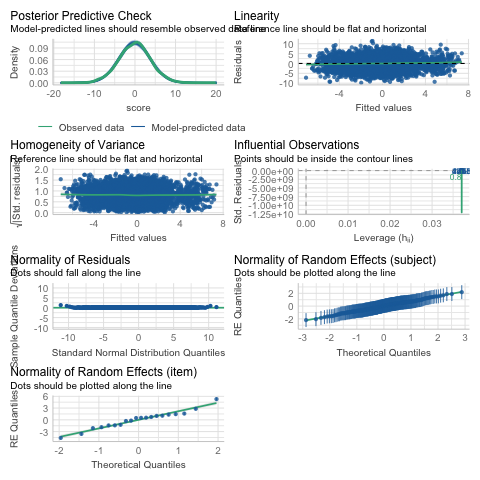

In [8]:
%%R

library(performance)
check_model(model)